<a href="https://colab.research.google.com/github/MilenaOehlers/generative_models_for_deep_radar_object_detection/blob/main/diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequities

tutorial: https://www.youtube.com/watch?app=desktop&v=a4Yfz2FxXiY

___________________________________________________________________

data wasnt readily available via torchvision, http error.

instead downloaded data and auxiliary files following LAST answer here:

https://github.com/pytorch/vision/issues/7545

In [ ]:
# account: milenaoehlers@gmail.com
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

100% 1.82G/1.82G [00:49<00:00, 41.8MB/s]
100% 1.82G/1.82G [00:49<00:00, 39.9MB/s]


In [ ]:
import zipfile

# Define the path to your zip file
file_path = '/content/drive/MyDrive/kaggle/stanford-cars-dataset.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle/stanford_cars/')  # Replace 'destination_folder' with your desired folder


In [ ]:
# following https://www.youtube.com/watch?app=desktop&v=a4Yfz2FxXiY

import torch, torchvision
import matplotlib.pyplot as plt

data = torchvision.datasets.StanfordCars(root="/content/drive/MyDrive/kaggle/",download=True)

# Model

## Forward Process - Noise Scheduler

In [ ]:
# larger beta (noise scheduler) = simultaneously larger shift and wider variance
# in distribution, equivalent to larger corruption (=more noise) each step
# we want to ultimately arrive at mean 0 with fixed variance in all direction
# adding noise in image generation is conducted pixelwise (& channelwise?)
# sweet spot between to little and too much noise addition per step
# here: linear noise, also possible: quadratic, sigmoid...
# no sequential noise needed as sequential gaussian sampling is still a gaussian
# sum of gaussian still a gaussian
# -> replace 1-beta_t with alphabar_t
# linear beta scheduler means beta value is increased linearly wiht timesteps
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
  return torch.linspace(start,end,timesteps)

def get_index_from_list(vals, t, x_shape):
  '''Returns specific index t of values vals while considering the batch dim'''
  batch_size = t.shape[0]
  out = vals.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,)*(len(x_shape)-1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
  noise = torch.randn_like(x_0)
  sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
  sqrt_one_minus_alpha_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, x_0.shape)
  return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alpha_cumprod_t.to(device) * noise.to(device), \
    noise.to(device)

# Define beta schedule
T = 200
betas = linear_beta_schedule(T)

# Pre-calculate different terms for closed form
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0/alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.-alphas_cumprod)
posterior_variance = betas * (1.-alphas_cumprod_prev)/(1.-alphas_cumprod)

In [ ]:
## Get & Transform Data

from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
  data_transforms = [
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(), #scales data into [0,1]
      transforms.Lambda(lambda t: (t*2)-1) # now to [-1,1]
  ]
  data_transform = transforms.Compose(data_transforms)
  train = torchvision.datasets.StanfordCars(root="/content/drive/MyDrive/kaggle/",
                                            download=True,transform=data_transform,
                                            split="train")
  print("train loaded")
  test = torchvision.datasets.StanfordCars(root="/content/drive/MyDrive/kaggle/",
              download=False,transform=data_transform, split="test")
  print("test loaded")
  return torch.utils.data.ConcatDataset([train,test])

def show_tensor_image(image):
  reverse_transforms = transforms.Compose([
      transforms.Lambda(lambda t: (t+1)/2),
      transforms.Lambda(lambda t: t.permute(1,2,0)), #CHW to HWC
      transforms.Lambda(lambda t: t*255),
      transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
      transforms.ToPILImage()
  ])

  if len(image.shape)==4:
    image = image[0,:,:,:]
  plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
#dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

train loaded
test loaded


In [ ]:
# later on, enumerate(dataloader) super slow despite using colab pro
# and A100 GPU
# try this solution found in https://discuss.pytorch.org/t/enumerate-dataloader-slow/87778/3
# to accelerate process
class MultiEpochsDataLoader(torch.utils.data.DataLoader):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._DataLoader__initialized = False
        self.batch_sampler = _RepeatSampler(self.batch_sampler)
        self._DataLoader__initialized = True
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)


class _RepeatSampler(object):
    """ Sampler that repeats forever.

    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)

dataloader = MultiEpochsDataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

<ipython-input-14-2c49963e1be9>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int((idx/stepsize)+1))


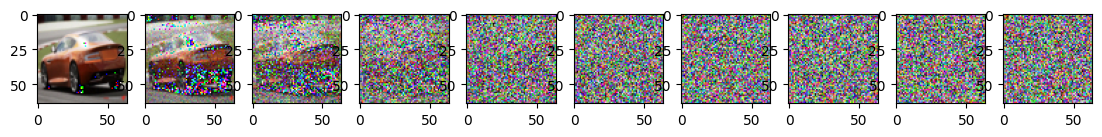

In [ ]:
# simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis("off")
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
  t = torch.Tensor([idx]).type(torch.int64)
  plt.subplot(1, num_images+1, int((idx/stepsize)+1))
  image,noise = forward_diffusion_sample(image, t)
  show_tensor_image(image)

## Backward Process - UNet
- Input: Noisy Image
- Output: Noise
- Tell network which timestep via transformer sinusoidal embedding
- Output mean of noise only, variance is fixed


In [ ]:
from torch import nn
import math

class Block(nn.Module):
  def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
    super().__init__()
    self.time_mlp = nn.Linear(time_emb_dim,out_ch)

    multi_in_ch, filter_type = {True: (2,nn.ConvTranspose2d),
                                False: (1,nn.Conv2d)}[up]
    self.conv1 = nn.Conv2d(multi_in_ch*in_ch, out_ch, 3, padding=1)
    self.transform = filter_type(out_ch, out_ch, 4,2,padding=1)
    # nn.ConvTranspose2d is "inverse" operator to conv2d
    # if they have the same weights, kernel size, padding=0 and
    # stride=1 and in_ch0=out_ch1 & out_ch0=in_ch1
    # hence nn.ConvTranspose2d upscales picture
    # conv2d downscales it

    self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    self.pool = nn.MaxPool2d(3, stride=2)
    self.bnorm = nn.BatchNorm2d(out_ch)
    # following paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
    self.relu = nn.ReLU()

  def forward(self,x,t,):
    h = self.bnorm(self.relu(self.conv1(x)))
    time_emb = self.relu(self.time_mlp(t))
    time_emb = time_emb[(..., ) + (None, )*2]
    # ... Ellipsis, fills in ":," until full dimension
    # slice(None) === ":"
    # None -> add one more single dimension here, so
    #   that a np.array([[1,2],[3,4]]) of dim (2,2) with [:,:,None]
    #   becomes np.array([[[1],[2]],[[3],[4]]])
    h = h + time_emb
    # huh, you add the time embedding onto the conv output
    # of the first convolution -> yup, see explanation in next class!
    h = self.bnorm(self.relu(self.conv2(h)))
    return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
  """Firstly used in transformers (Attention is all you need), to encode positions
  that are not naturally accounted for by the model anymore, as opposed to the
  RNN model;
  following https://kazemnejad.com/blog/transformer_architecture_positional_encoding/:
  in transformer: alternatives to sinusoidalPositionEncoding:
  - [0,1] range: problems: a) total num of words unclear,
                           b) meaning of time-step delta unclear
  - 0,1,2,3,...: problems: a) pos. encoding numbers can get quite large
                           b) when validation sentences longer than in traning
                           c) sentences of specific lengths might not be seen

  criteria to be met for ideal positional encoding:
  - unique encoding for each time step
  - time delta consistent across sentences of different lengths
  - bounded values, generalizability to longer sentences
  - deterministic
  proposed method: sinusoidalPositionalEmbedding:
  positional encoding is vetor, namely
  p_t^(i) = (sin if i==2k else cos if i==2k+1)(t/10000^(2*k/d)) (here: d==20)
  p_t = [sin(w_1*t), cos(w_1*t),sin(w_2*t),cos(w_2*t),...,
         sin(w_(d/2)*t), cos(w_(d/2)*t)]_(d x 1)
  underlying idea: binary format representation:
  0: 0000
  1: 0001
  2: 0010
  3: 0011
  4: 0100 ...
  hence, frequency of change dependant on bit positon. Transfer this idea into
  continuous space (floats)
  ** look at nice position-depth illustration of positional encoding vector**
  Now, to add embedding to word (literally), set d(word embed=f(w_t))==d(pos embed)
  f'(w_t)=f(w_t)+p_t for every word w_t in a sentence
  another advantage: orelative positions easily clear to model, since for any
  fixed offset k, PE(t+d) = M*PE(t) (no bias a required appearantly)
  [proof: for any sine-cosine pair corr. to freq w_k, ex. a lin trafo M in R^(2x2)
          thats independent of t, with
          M*[sin(w_k*t), cos(w_k*t)] = [sin(w_k*(t+d)), cos(w_k*(t+d))]
          (using addition theorem)
          => M(d,k) = [[ cos(w_k*d), sin(w_k*d)],
                       [-sin(w_k*d), cos(w_k*d)]] (similar to rotation matrix),
          yielding p_(t+d) a lin trafo of p_t of any fixed offset d]
  also, distance between neighboring time steps symmetrical and decays nicely
  with time **see dot-product of position embeddings illustration**
  why addition instead of concatenation? -> less additional parameters"""
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self,time):
      device = time.device
      half_dim = self.dim // 2
      embeddings = math.log(10000) / (half_dim - 1)
      embeddings = torch.exp(torch.arange(half_dim, device=device)*-embeddings)
      embeddings = time[:,None] * embeddings[None, :]
      embeddings = torch.cat((embeddings.sin(), embeddings.cos()),dim=-1)
      return embeddings

class SimpleUnet(nn.Module):
  def __init__(self):
    super().__init__()
    image_size = IMG_SIZE
    image_channels = 3
    down_channels = (64,128,256,512,1024)
    up_channels = (1024,512,256,128,64)
    out_dim = 1
    time_emb_dim = 32

    self.time_mlp = nn.Sequential(
        SinusoidalPositionEmbeddings(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.ReLU()
    )
    self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
    self.downs = nn.ModuleList([Block(*down_channels[i:i+2],time_emb_dim)
                                for i in range(len(down_channels)-1)])
    self.ups = nn.ModuleList([Block(*up_channels[i:i+2], time_emb_dim, up=True)
                              for i in range(len(up_channels)-1)])
    self.output = nn.Conv2d(up_channels[-1],3,out_dim)

  def forward(self,x,timestep):
    t = self.time_mlp(timestep)
    x = self.conv0(x)
    residual_inputs = []
    for down in self.downs:
      x = down(x,t)
      residual_inputs.append(x)
    for up in self.ups:
      residual_x = residual_inputs.pop()
      x = torch.cat((x,residual_x), dim=1)
      x = up(x,t)
    return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62433123


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2

## Loss Function

In [ ]:
def get_loss(model,x_0,t):
  x_noisy, noise = forward_diffusion_sample(x_0,t,device)
  noise_pred = model(x_noisy, t)
  return F.l1_loss(noise, noise_pred)

In [ ]:
# iot not run out of memory:
@torch.no_grad()
def sample_timestep(x,t):
  '''Calls the model to predict the noise in the image and returns the denoised
  image. Applies noise to this image, if we are not in the last step yet.'''
  betas_t = get_index_from_list(betas,t,x.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, x.shape
  )
  sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas,t, x.shape)
  model_mean = sqrt_recip_alphas_t * (
      x - betas_t * model(x,t) / sqrt_one_minus_alphas_cumprod_t
  )
  posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

  if t==0:
    return model_mean
  else:
    noise = torch.randn_like(x)
    return model_mean + torch.sqrt(posterior_variance_t)*noise

@torch.no_grad()
def sample_plot_image():
  img_size = IMG_SIZE
  img = torch.randn((1,3,img_size,img_size),device=device)
  plt.figure(figsize=(15,15))
  plt.axis("off")
  num_images=10
  stepsize=int(T/num_images)

  for i in range(T)[::-1]:
    t = torch.full((1,), i, device=device,dtype=torch.long)
    img = sample_timestep(img, t)
    if i% stepsize == 0:
      plt.subplot(1, num_images, int(i/stepsize)+1)
      show_tensor_image(img.detach().cpu())
  plt.show()

# Training

Epoch 0 | step 000 Loss: 0.5571385622024536 


<ipython-input-10-304506f2c348>:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


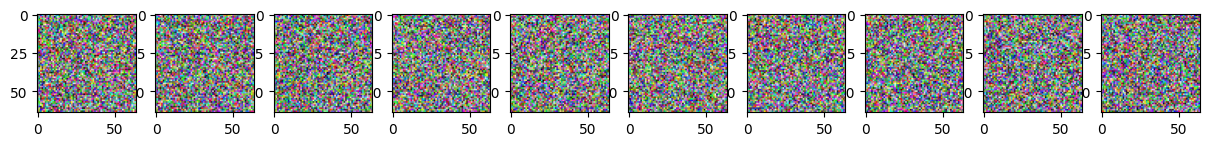

KeyboardInterrupt: 

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
  step = 0
  for batch in dataloader:
    optimizer.zero_grad()

    t = torch.randint(0,T,(BATCH_SIZE,), device=device).long()
    loss = get_loss(model, batch[0], t)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      sample_plot_image()
    step += 1

In [ ]:
device

'cuda'